In [110]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
# -*- coding: UTF-8 -*-

## 图像形态学操作

In [40]:
def add_salt_to_img(img: np.array, n: int) -> np.array:  
    '''对图像添加椒盐噪声
    
    输入一张图像，对图像添加n个椒盐噪声点。
    Args: 
        img: RGB图像或者灰度图像
        n: 椒盐数目
    Return:
        返回添加椒盐噪声后的图像
    '''  
    img_copy = img.copy()
    for k in range(n):    
        i = int(np.random.random() * img_copy.shape[1])
        j = int(np.random.random() * img_copy.shape[0])
        if img_copy.ndim == 2:     
            img_copy[j,i] = 255    
        elif img_copy.ndim == 3:     
            img_copy[j,i,0]= 255    
            img_copy[j,i,1]= 255    
            img_copy[j,i,2]= 255    
    return img_copy   

def eroded(mask: np.array, kernel_size: int) -> np.array:
    """对图像进行腐蚀

    输入一张图像和腐蚀操作的kernel_size，返回腐蚀操作的结果
    Args: 
        img: 二值图像
        kernel_size: int型，指定kernel大小
    Return: 
        返回腐蚀操作后的图像
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    eroded = cv2.erode(mask, kernel)
    return eroded

def dilated(mask, kernel_size):
    """对图像进行膨胀

    输入一张图像和膨胀操作的kernel_size，返回膨胀操作的结果
    Args: 
        img: 二值图像
        kernel_size: int型，指定kernel大小
    Return: 
        返回膨胀操作后的图像
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    dilated = cv2.dilate(mask, kernel)
    return dilated

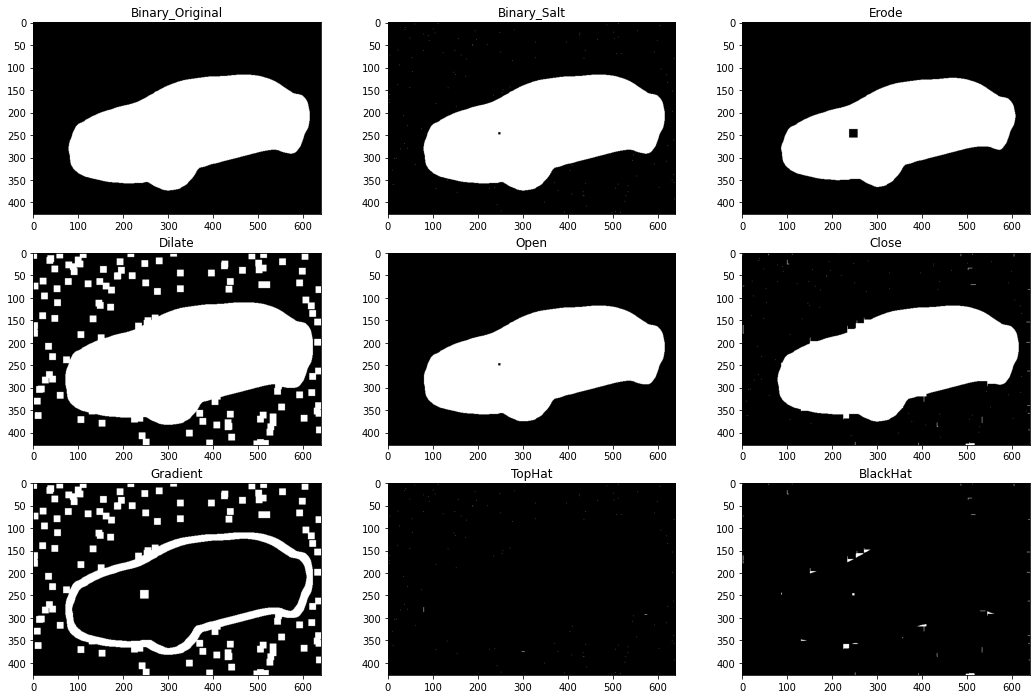

In [43]:
img = cv2.imread("../demo_images/car.png", cv2.IMREAD_UNCHANGED) #RGBA的形式读图，这张图的A通道比较特殊，是汽车图像分割结果，数值范围是[0,255]的双闭区间
img_mask = img[:,:,-1] #取出图像的A通道
thresh, binary_mask = cv2.threshold(img_mask, thresh=127.0, maxval=255, type=cv2.THRESH_BINARY) #对A通道进行二值化操作，二值化阈值为127.0
binary_mask_salt = add_salt_to_img(binary_mask, 200) #对binary_mask添加200个椒盐噪声
# binary_mask_salt[245:250,245:250] = 0 #在binary_mask_salt加一个黑洞

methods = ["Binary_Original", "Binary_Salt", "Erode", "Dilate", "Open", "Close", "Gradient", "TopHat", "BlackHat"]

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(18, 12))
axes = ax.flatten() 

eroded_img = eroded(binary_mask_salt, 15) #腐蚀操作
dilated_img = dilated(binary_mask_salt, 15) #膨胀操作
open_img = dilated(eroded(binary_mask_salt, 15), 15) #开操作
close_img = eroded(dilated(binary_mask_salt, 15), 15) #闭操作
gradient_img = dilated_img - eroded_img #图像的形态学梯度
top_hat_img = binary_mask_salt - open_img #顶帽操作
black_hat_img = close_img - binary_mask_salt #黑帽操作

axes[0].imshow(binary_mask, cmap="gray")
axes[1].imshow(binary_mask_salt, cmap="gray")
axes[2].imshow(eroded_img, cmap="gray")
axes[3].imshow(dilated_img, cmap="gray")
axes[4].imshow(open_img, cmap="gray")
axes[5].imshow(close_img, cmap="gray")
axes[6].imshow(gradient_img, cmap="gray")
axes[7].imshow(top_hat_img, cmap="gray")
axes[8].imshow(black_hat_img, cmap="gray")

for idx, method in enumerate(methods):
    axes[idx].set_title(method)

plt.savefig("../course_images/dilate_erode.jpg", dpi = 300)

## 直方图及其均衡化

In [226]:

def arrayToHist(grayImage: np.array, bin_nums: int, norm: bool = True) -> dict:
    """统计灰度图的直方图

    将灰度数组映射为直方图字典,nums表示灰度的数量级

    Args:
        grayImage: 灰度图
        bin_nums: 灰度数量级
        norm: 是否对直方图统计结果做标准化处理

    Return:
        直方图字典，例如:
        {0:0.1,1:0.03,...,255:0.076}

    Raises:
        ValueError: 当传入的图像不是合格灰度图时会抛出异常
    """
    if(len(grayImage.shape) != 2):
        raise ValueError

    w, h = grayImage.shape
    hist = {}

    for value in list(grayImage.flatten()):
        hist_bin = value % bin_nums
        hist.setdefault(hist_bin, 0)
        hist[hist_bin] += 1
    
    # 归一化
    if norm:
        n = w*h
        for key in hist.keys():
            hist[key] = float(hist[key])/n 

    return hist

def drawHist(hist: dict) -> None:
    """绘制直方图

    以字典的格式传入的直方图

    Args:
        hist: 直方图字典，例如:
        {0:0.1,1:0.03,...,255:0.076}
    
    Return: 
        None 
    """
    keys = hist.keys()
    values = hist.values()
    plt.bar(tuple(keys),tuple(values), width=1.2)
    plt.show()
    return 

### 直方图统计结果

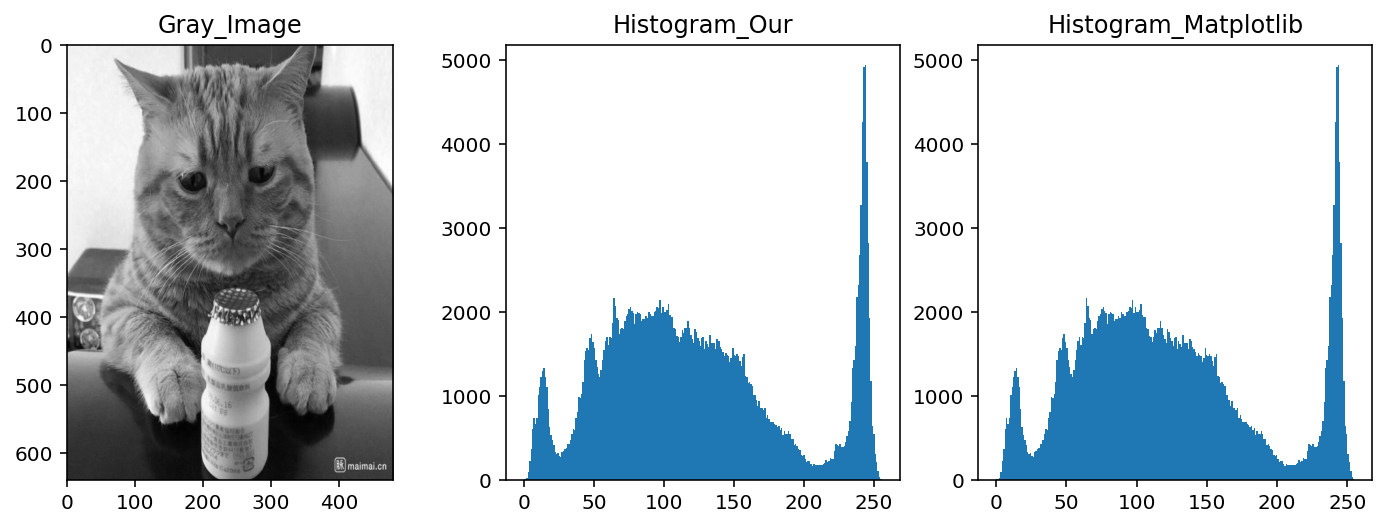

In [241]:
img_gray = cv2.imread("../demo_images/little_cat.jpg", cv2.IMREAD_GRAYSCALE) 

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Gray_Image")
plt.imshow(img_gray,cmap = 'gray')

#统计直方图
plt.subplot(1,3,2)
plt.title("Histogram_Our")
hist = arrayToHist(img_gray, bin_nums = 256, norm = False)
drawHist(hist)

# 我们对比下matplotlib的官方实现
plt.subplot(1,3,3)
plt.title("Histogram_Matplotlib")
plt.hist(img_gray.flatten(), bins=256)
plt.show()

plt.show()
plt.savefig("../course_images/histogram.jpg", dpi = 300)

### 直方图均衡化

In [189]:
def equalization(grayImage: np.array, bin_nums: int) -> np.array:
    """直方图均衡化
    
    计算累计直方图计算出直方图均衡化后的图片

    Args:
        grayImage: 灰度图
        bin_nums: 灰度数量级

    Return:
        返回直方图均衡化后的图片
    
    Raises:
        ValueError: 当传入的图像不是合格灰度图时会抛出异常
    """

    if(len(grayImage.shape) != 2):
        raise ValueError

    hist = arrayToHist(grayImage, bin_nums = bin_nums)
    cdf = np.array(list(hist.values())).cumsum() #计算累计分布函数
    cdf = 255 * cdf / cdf[-1] #将累计分布的结果映射到[0,255]
    bins = sorted(list(hist.keys())) #对直方图对应的像素值区间升序排序

    """
    采用np.interp进行插值，此处的bins和cdf都是升序，并且数值范围都是[0,255]。
    bins和cdf可以构成一条分段函数曲线，对于grayImage.flatten()的每一个数值
    可以作为x值，在分段函数曲线上获取y值即为插值结果
    """
    img_equalized = np.interp(grayImage.flatten(), bins, cdf) 
    return img_equalized.reshape(grayImage.shape).astype(np.uint8)

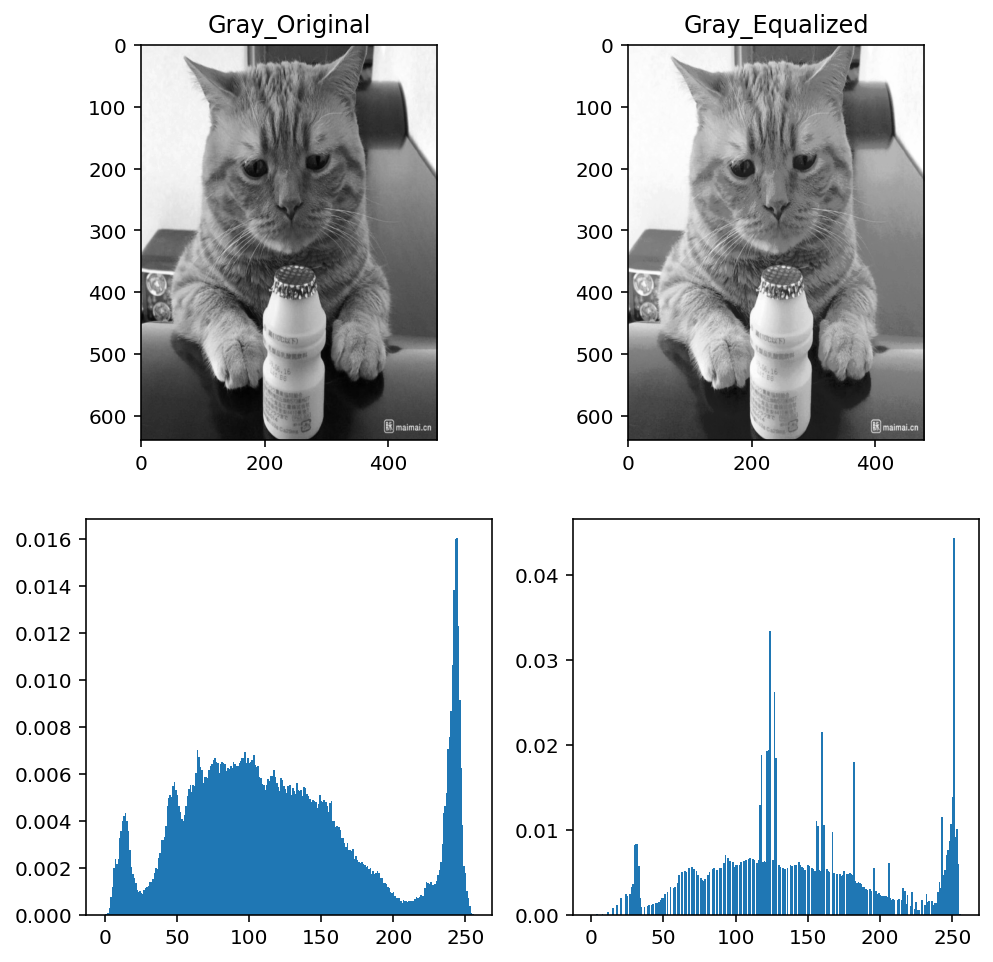

In [243]:
img_gray = cv2.imread("../demo_images/little_cat.jpg", cv2.IMREAD_GRAYSCALE) 

plt.figure(figsize = (8,8))
plt.subplot(2,2,1)
plt.imshow(img_gray,cmap = 'gray')
plt.title("Gray_Original")

plt.subplot(2,2,3)
hist = arrayToHist(img_gray, bin_nums = 256)
drawHist(hist)

# 直方图均衡化
img_equalized = equalization(img_gray, bin_nums = 256)
plt.subplot(2,2,2)
plt.imshow(img_equalized, cmap = 'gray')
plt.title("Gray_Equalized")

plt.subplot(2,2,4)
hist = arrayToHist(img_equalized, bin_nums = 256)
drawHist(hist)

plt.show()
plt.savefig("../course_images/histogram_equalization.jpg", dpi = 300)

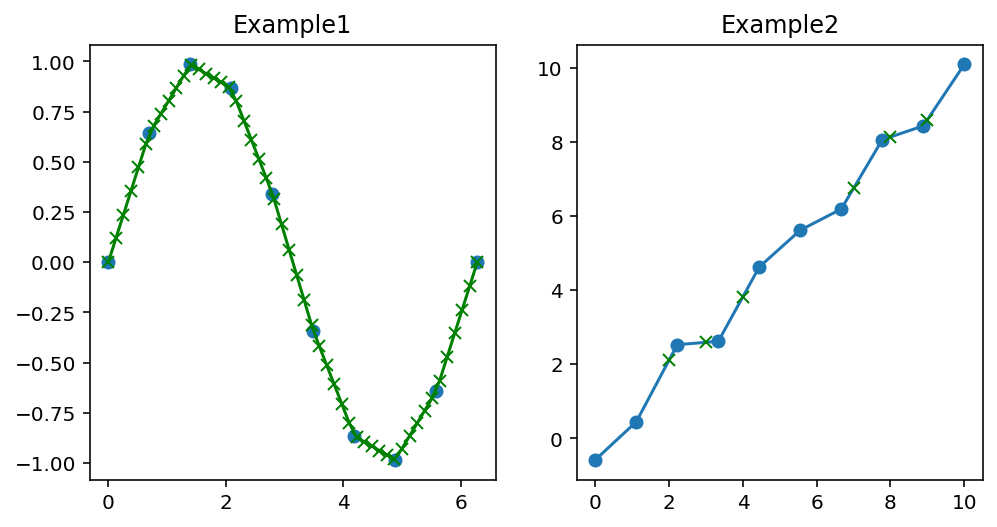

In [261]:
# 关于np.interp这个函数的用法你可能有疑惑，看下下面的两个例子就明白了！

# 示例1：
x = np.linspace(0, 2 * np.pi, 10)
y = np.sin(x)
xvals = np.linspace(0, 2 * np.pi, 50)
yinterp = np.interp(xvals, x, y)

plt.figure(figsize = (8, 4))
plt.subplot(1,2,1)
plt.plot(x, y, 'o')
plt.plot(xvals, yinterp, '-x', color = "green")
plt.title("Example1")


# 示例2：
x = np.linspace(0, 10, 10)
y = np.linspace(0, 10, 10) + np.random.uniform(-0.8, 0.8, 10)
before_interp = np.array([7, 3, 9, 2, 4, 8])
yinterp = np.interp(before_interp, x, y)
plt.subplot(1, 2, 2)
plt.plot(x, y, '-o')
plt.plot(before_interp, yinterp, 'x', color = "green")
plt.title("Example2")
plt.show()

plt.savefig("../course_images/np_interp.jpg", dpi = 300)

## Resize操作及插值方法 

In [295]:
def custom_resize_nearest(img: np.array, size: tuple) -> np.array:
    """使用最近邻插值的形式对图像进行缩放

    输入一张图像，指定缩放后图像的尺寸，使用最近邻的方式对原图进行缩放后返回。

    Args:
        img: 原始图像，当前仅支持三通道
        size: 缩放后尺寸，当前仅支持tuple形式
    
    Return:
        返回缩放后的图像

    Raises:
        ValueError: 当图像格式或者缩放尺寸不符合规范时抛出ValueError异常
    """

    if len(img.shape) != 3:
        raise ValueError
 
    source_height, source_width = img.shape[:2]
    target_width, target_height = size

    if target_width * target_height == 0:
        raise ValueError

    height_ratio = source_height / float(target_height)
    width_ratio = source_width / float(target_width)

    target_img = np.zeros((target_width, target_height, 3))

    for row in range(target_height):
        for col in range(target_width):

            source_x = min(source_width - 1, round(col * width_ratio))
            source_y = min(source_height - 1, round(row * height_ratio))
            
            for channel in range(3):
                target_img[row, col, channel] = img[source_y, source_x, channel]
    
    return target_img.astype(np.uint8)

    

In [296]:
def custom_resize_bilinear(img: np.array, size: tuple) -> np.array:
    """使用双线性插值的形式对图像进行缩放

    输入一张图像，指定缩放后图像的尺寸，使用双线性的方式对原图进行缩放后返回。

    Args:
        img: 原始图像，当前仅支持三通道
        size: 缩放后尺寸，当前仅支持tuple形式
    
    Return:
        返回缩放后的图像

    Raises:
        ValueError: 当图像格式或者缩放尺寸不符合规范时抛出ValueError异常
    """

    if len(img.shape) != 3:
        raise ValueError
 
    source_height, source_width = img.shape[:2]
    target_width, target_height = size

    if target_width * target_height == 0:
        raise ValueError

    height_ratio = source_height / float(target_height)
    width_ratio = source_width / float(target_width)

    target_img = np.zeros((target_width, target_height, 3))

    for row in range(target_height):
        for col in range(target_width):

            right_weight = col * width_ratio - int(col * width_ratio)
            bottom_weight = row * height_ratio - int(row * height_ratio)
            left_weight = 1.0 - right_weight
            upper_weight = 1.0 - bottom_weight
            
            source_x = int(col * width_ratio)
            source_y = int(row * height_ratio)
            left_upper_source_x = max(0, source_x - 1)
            left_upper_source_y = max(0, source_y - 1)
            right_upper_source_x = min(source_width - 1, source_x + 1)
            right_upper_source_y = max(0, source_y - 1)
            left_bottom_source_x = max(0, source_x - 1)
            left_bottom_source_y = min(source_height - 1, source_y + 1)
            right_bottom_source_x = min(source_width - 1, source_x + 1)
            right_bottom_source_y = min(source_height - 1, source_y + 1)
            
            for channel in range(3):
                pt1 = img[left_upper_source_y, left_upper_source_x, channel]
                pt2 = img[right_upper_source_y, right_upper_source_x, channel]
                pt3 = img[left_bottom_source_y, left_bottom_source_x, channel]
                pt4 = img[right_bottom_source_y, right_bottom_source_x, channel]

                inter_p1 = pt1 * left_weight + pt2 * right_weight
                inter_p2 = pt3 * left_weight + pt4 * right_weight 

                target_img[row, col, channel] = int(upper_weight * inter_p1 + bottom_weight * inter_p2)
    
    return target_img.astype(np.uint8)

    

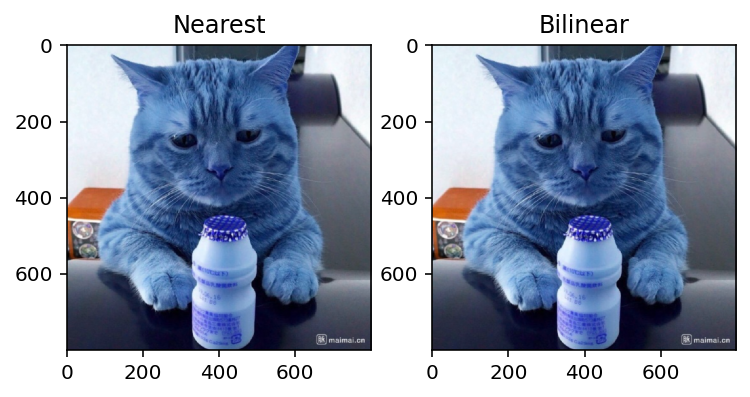

In [300]:
img_bgr = cv2.imread("../demo_images/little_cat.jpg", cv2.IMREAD_COLOR)
img_bgr_enlarge = custom_resize_nearest(img_bgr, (800, 800))
img_bgr_bilinear = custom_resize_nearest(img_bgr, (800, 800))
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 12))
axes = ax.flatten() 
axes[0].imshow(img_bgr_enlarge)
axes[0].set_title("Nearest")
axes[1].imshow(img_bgr_bilinear)
axes[1].set_title("Bilinear")
plt.show()
plt.savefig("../course_images/interp_img.jpg", dpi = 300)
